<center>
    <h1>[Training] - FastAI Baseline</h1>
<center>

<center>
<img src="https://hubmapconsortium.org/wp-content/uploads/2019/01/HuBMAP-Retina-Logo-Color.png">
</center>

# Description 

Welcome to Human BioMolecular Atlas Program (HuBMAP) + Human Protein Atlas (HPA) competition. 
The objective of this challenge is segmentation of functional tissue units (FTU. e.g., glomeruli in kidney or alveoli in the lung) in biopsy slides from several different organs. 
The underlying data includes imagery from different sources prepared with different protocols at a variety of resolutions, reflecting typical challenges for working with medical data.

This notebook provides a fast.ai starter Pytorch code based on a U-shape network (UneXt50) that was used on multiple competitions in the past and includes several tricks from the previous segmentation competitions.
It is [dividing the images into tiles](https://www.kaggle.com/code/thedevastator/converting-to-256x256), selection of tiles with tissue, evaluation of the predictions of multiple models with TTA, combining the tile masks back into image level masks, and conversion into RLE. The [inference](https://www.kaggle.com/code/thedevastator/inference-fastai-baseline) is performed based on models trained in the [fast.ai training notebook](https://www.kaggle.com/code/thedevastator/training-fastai-baseline).

**Inference & Dataset Creation**

- #### Inference Notebook [here](https://www.kaggle.com/code/thedevastator/inference-fastai-baseline). 
- #### Dataset Creation [here](https://www.kaggle.com/code/thedevastator/converting-to-256x256). 

**Precomputed Datasets**

- ##### [Dataset (512 x 512)](https://www.kaggle.com/datasets/thedevastator/hubmap-2022-512x512/)

- ##### [Dataset (256 x 256)](https://www.kaggle.com/datasets/thedevastator/hubmap-2022-256x256/)

- ##### [Dataset (128 x 128)](https://www.kaggle.com/datasets/thedevastator/hubmap-2022-128x128/settings)

____

#### Everything is based on the excellent [notebooks](https://www.kaggle.com/code/iafoss/hubmap-pytorch-fast-ai-starter) by [iafoss](https://www.kaggle.com/iafoss) 
All credit to belongs to the original author!
____

In [1]:
"""
Lovasz-Softmax and Jaccard hinge loss in PyTorch
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / union
        ious.append(iou)
    iou = f_mean(ious)    # mean accross images if per_image
    return 100 * iou


def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []    
        for i in range(C):
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / union)
        ious.append(iou)
    ious = map(f_mean, zip(*ious)) # mean accross images if per_image
    return 100 * np.array(ious)


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = f_mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    #loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    loss = torch.dot(F.elu(errors_sorted)+1, Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


class StableBCELoss(torch.nn.modules.Module):
    def __init__(self):
         super(StableBCELoss, self).__init__()
    def forward(self, input, target):
         neg_abs = - input.abs()
         loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
         return loss.mean()


def binary_xloss(logits, labels, ignore=None):
    """
    Binary Cross entropy loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      ignore: void class id
    """
    logits, labels = flatten_binary_scores(logits, labels, ignore)
    loss = StableBCELoss()(logits, Variable(labels.float()))
    return loss


# --------------------------- MULTICLASS LOSSES ---------------------------


def lovasz_softmax(probas, labels, only_present=False, per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = f_mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), only_present=only_present)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), only_present=only_present)
    return loss


def lovasz_softmax_flat(probas, labels, only_present=False):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
    """
    C = probas.size(1)
    losses = []
    for c in range(C):
        fg = (labels == c).float() # foreground for class c
        if only_present and fg.sum() == 0:
            continue
        errors = (Variable(fg) - probas[:, c]).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return f_mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.nonzero().squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def xloss(logits, labels, ignore=None):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), ignore_index=255)


# --------------------------- HELPER FUNCTIONS ---------------------------

def f_mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision.all import *
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import cv2
import gc
import random
from albumentations import *
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
bs = 64
nfolds = 4
fold = 0
SEED = 2021
TRAIN = '../input/hubmap-2022-256x256/train/'
MASKS = '../input/hubmap-2022-256x256/masks/'
LABELS = '../input/hubmap-organ-segmentation/train.csv'
NUM_WORKERS = 4

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #the following line gives ~10% speedup
    #but may lead to some stochasticity in the results 
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

# Data
One important thing here is the train/val split. To avoid possible leaks resulted by a similarity of tiles from the same images, it is better to keep tiles from each image together in train or in test.

In [5]:
# https://www.kaggle.com/datasets/thedevastator/hubmap-2022-256x256
mean = np.array([0.7720342, 0.74582646, 0.76392896])
std = np.array([0.24745085, 0.26182273, 0.25782376])

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class HuBMAPDataset(Dataset):
    def __init__(self, fold=fold, train=True, tfms=None):
        ids = pd.read_csv(LABELS).id.astype(str).values
        kf = KFold(n_splits=nfolds,random_state=SEED,shuffle=True)
        ids = set(ids[list(kf.split(ids))[fold][0 if train else 1]])
        self.fnames = [fname for fname in os.listdir(TRAIN) if fname.split('_')[0] in ids]
        self.train = train
        self.tfms = tfms
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.cvtColor(cv2.imread(os.path.join(TRAIN,fname)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(MASKS,fname),cv2.IMREAD_GRAYSCALE)
        if self.tfms is not None:
            augmented = self.tfms(image=img,mask=mask)
            img,mask = augmented['image'],augmented['mask']
        return img2tensor((img/255.0 - mean)/std),img2tensor(mask)
    
def get_aug(p=1.0):
    return Compose([
        HorizontalFlip(),
        VerticalFlip(),
        RandomRotate90(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        OneOf([
            HueSaturationValue(10,15,10),
            CLAHE(clip_limit=2),
            RandomBrightnessContrast(),            
        ], p=0.3),
    ], p=p)

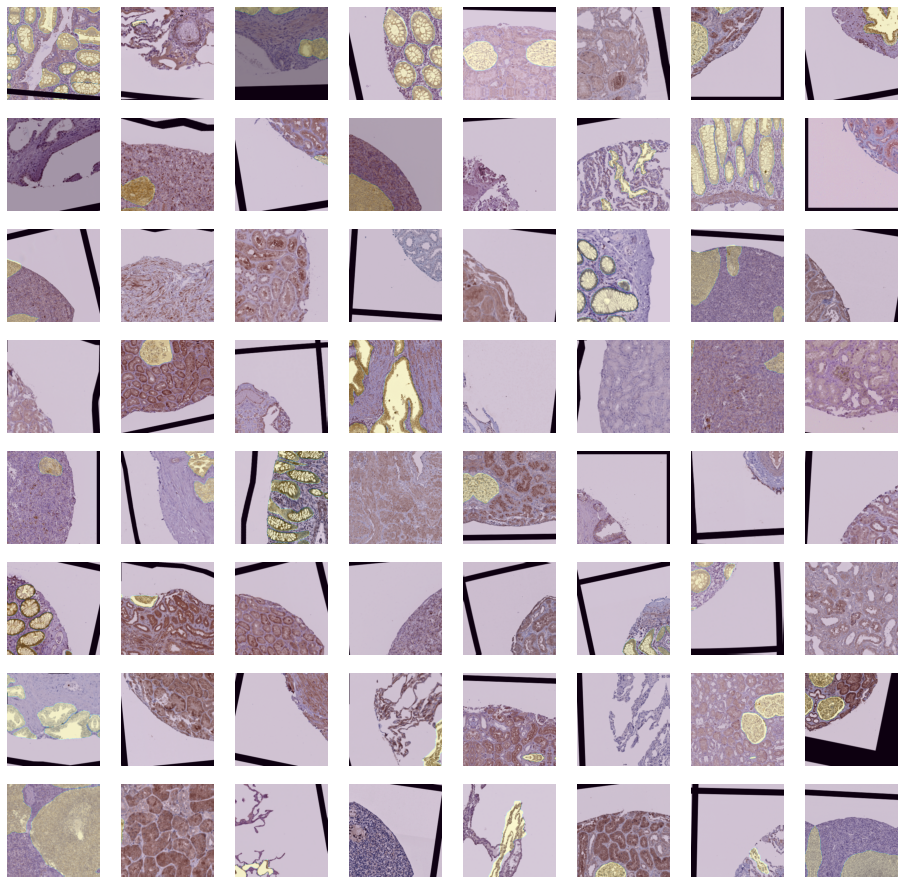

In [6]:
#example of train images with masks
ds = HuBMAPDataset(tfms=get_aug())
dl = DataLoader(ds,batch_size=64,shuffle=False,num_workers=NUM_WORKERS)
imgs,masks = next(iter(dl))

plt.figure(figsize=(16,16))
for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0)*std + mean)*255.0).numpy().astype(np.uint8)
    plt.subplot(8,8,i+1)
    plt.imshow(img,vmin=0,vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    
del ds,dl,imgs,masks

# Model
The model used in this kernel is based on a U-shape network (UneXt50, see image below), which I used in Severstal and Understanding Clouds competitions. The idea of a U-shape network is coming from a [Unet](https://arxiv.org/pdf/1505.04597.pdf) architecture proposed in 2015 for medical images: the encoder part creates a representation of features at different levels, while the decoder combines the features and generates a prediction as a segmentation mask. The skip connections between encoder and decoder allow us to utilize features from the intermediate conv layers of the encoder effectively, without a need for the information to go the full way through entire encoder and decoder. The latter is especially important to link the predicted mask to the specific pixels of the detected object. Later people realized that ImageNet pretrained computer vision models could drastically improve the quality of a segmentation model because of optimized architecture of the encoder, high encoder capacity (in contrast to one used in the original Unet), and the power of the transfer learning.

There are several important things that must be added to a Unet network, however, to make it able to reach competitive results with current state of the art approaches. First, it is **Feature Pyramid Network (FPN)**: additional skip connection between different upscaling blocks of the decoder and the output layer. So, the final prediction is produced based on the concatenation of U-net output with resized outputs of the intermediate layers. These skip-connections provide a shortcut for gradient flow improving model performance and convergence speed. Since intermediate layers have many channels, their upscaling and use as an input for the final layer would introduce a significant overhead in terms of the computational time and memory. Therefore, 3x3+3x3 convolutions are applied (factorization) before the resize to reduce the number of channels.

Another very important thing is the **Atrous Spatial Pyramid Pooling (ASPP) block** added between encoder and decoder. The flaw of the traditional U-shape networks is resulted by a small receptive field. Therefore, if a model needs to make a decision about a segmentation of a large object, especially for a large image resolution, it can get confused being able to look only into parts of the object. A way to increase the receptive field and enable interactions between different parts of the image is use of a block combining convolutions with different dilatations ([Atrous convolutions](https://arxiv.org/pdf/1606.00915.pdf) with various rates in ASPP block). While the original paper uses 6,12,18 rates, they may be customized for a particular task and a particular image resolution to maximize the performance. One more thing I added is using group convolutions in ASPP block to reduce the number of model parameters.

Finally, the decoder upscaling blocks are based on [pixel shuffle](https://arxiv.org/pdf/1609.05158.pdf) rather than transposed convolution used in the first Unet models. It allows to avoid artifacts in the produced masks. And I use [semisupervised Imagenet pretrained ResNeXt50](https://github.com/facebookresearch/semi-supervised-ImageNet1K-models) model as a backbone. In Pytorch it provides the performance of EfficientNet B2-B3 with much faster convergence for the computational cost and GPU RAM requirements of EfficientNet B0 (though, in TF EfficientNet is highly optimized and may be a good thing to use).

![](https://i.ibb.co/z5KxDzm/Une-Xt50-1.png)

In [7]:
class FPN(nn.Module):
    def __init__(self, input_channels:list, output_channels:list):
        super().__init__()
        self.convs = nn.ModuleList(
            [nn.Sequential(nn.Conv2d(in_ch, out_ch*2, kernel_size=3, padding=1),
             nn.ReLU(inplace=True), nn.BatchNorm2d(out_ch*2),
             nn.Conv2d(out_ch*2, out_ch, kernel_size=3, padding=1))
            for in_ch, out_ch in zip(input_channels, output_channels)])
        
    def forward(self, xs:list, last_layer):
        hcs = [F.interpolate(c(x),scale_factor=2**(len(self.convs)-i),mode='bilinear') 
               for i,(c,x) in enumerate(zip(self.convs, xs))]
        hcs.append(last_layer)
        return torch.cat(hcs, dim=1)

class UnetBlock(Module):
    def __init__(self, up_in_c:int, x_in_c:int, nf:int=None, blur:bool=False,
                 self_attention:bool=False, **kwargs):
        super().__init__()
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        self.bn = nn.BatchNorm2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = nf if nf is not None else max(up_in_c//2,32)
        self.conv1 = ConvLayer(ni, nf, norm_type=None, **kwargs)
        self.conv2 = ConvLayer(nf, nf, norm_type=None,
            xtra=SelfAttention(nf) if self_attention else None, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, up_in:Tensor, left_in:Tensor) -> Tensor:
        s = left_in
        up_out = self.shuf(up_in)
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))
        
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, groups=1):
        super().__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                stride=1, padding=padding, dilation=dilation, bias=False, groups=groups)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class ASPP(nn.Module):
    def __init__(self, inplanes=512, mid_c=256, dilations=[6, 12, 18, 24], out_c=None):
        super().__init__()
        self.aspps = [_ASPPModule(inplanes, mid_c, 1, padding=0, dilation=1)] + \
            [_ASPPModule(inplanes, mid_c, 3, padding=d, dilation=d,groups=4) for d in dilations]
        self.aspps = nn.ModuleList(self.aspps)
        self.global_pool = nn.Sequential(nn.AdaptiveMaxPool2d((1, 1)),
                        nn.Conv2d(inplanes, mid_c, 1, stride=1, bias=False),
                        nn.BatchNorm2d(mid_c), nn.ReLU())
        out_c = out_c if out_c is not None else mid_c
        self.out_conv = nn.Sequential(nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False),
                                    nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))
        self.conv1 = nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False)
        self._init_weight()

    def forward(self, x):
        x0 = self.global_pool(x)
        xs = [aspp(x) for aspp in self.aspps]
        x0 = F.interpolate(x0, size=xs[0].size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x0] + xs, dim=1)
        return self.out_conv(x)
    
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [8]:
class UneXt50(nn.Module):
    def __init__(self, stride=1, **kwargs):
        super().__init__()
        #encoder
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models',
                           'resnext50_32x4d_ssl')
        self.enc0 = nn.Sequential(m.conv1, m.bn1, nn.ReLU(inplace=True))
        self.enc1 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1),
                            m.layer1) #256
        self.enc2 = m.layer2 #512
        self.enc3 = m.layer3 #1024
        self.enc4 = m.layer4 #2048
        #aspp with customized dilatations
        self.aspp = ASPP(2048,256,out_c=512,dilations=[stride*1,stride*2,stride*3,stride*4])
        self.drop_aspp = nn.Dropout2d(0.5)
        #decoder
        self.dec4 = UnetBlock(512,1024,256)
        self.dec3 = UnetBlock(256,512,128)
        self.dec2 = UnetBlock(128,256,64)
        self.dec1 = UnetBlock(64,64,32)
        self.fpn = FPN([512,256,128,64],[16]*4)
        self.drop = nn.Dropout2d(0.1)
        self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
        
    def forward(self, x):
        enc0 = self.enc0(x)
        enc1 = self.enc1(enc0)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.aspp(enc4)
        dec3 = self.dec4(self.drop_aspp(enc5),enc3)
        dec2 = self.dec3(dec3,enc2)
        dec1 = self.dec2(dec2,enc1)
        dec0 = self.dec1(dec1,enc0)
        x = self.fpn([enc5, dec3, dec2, dec1], dec0)
        x = self.final_conv(self.drop(x))
        x = F.interpolate(x,scale_factor=2,mode='bilinear')
        return x

#split the model to encoder and decoder for fast.ai
split_layers = lambda m: [list(m.enc0.parameters())+list(m.enc1.parameters())+
                list(m.enc2.parameters())+list(m.enc3.parameters())+
                list(m.enc4.parameters()),
                list(m.aspp.parameters())+list(m.dec4.parameters())+
                list(m.dec3.parameters())+list(m.dec2.parameters())+
                list(m.dec1.parameters())+list(m.fpn.parameters())+
                list(m.final_conv.parameters())]

# Loss and metric
A famous loss for image segmentation is the [Lovász loss](https://arxiv.org/pdf/1705.08790.pdf), a surrogate of IoU. Following [iafoss](https://www.kaggle.com/iafoss)'s [work](https://www.kaggle.com/code/iafoss/hubmap-pytorch-fast-ai-starter):
- **ReLU in it must be replaced by (ELU + 1)**(, like he did [here](https://www.kaggle.com/iafoss/lovasz).
- **Symmetric Lovász loss:** consider not only a predicted segmentation and a provided mask but also the inverse prediction and the inverse mask (predict mask for negative case).

In [9]:
def symmetric_lovasz(outputs, targets):
    return 0.5*(lovasz_hinge(outputs, targets) + lovasz_hinge(-outputs, 1.0 - targets))

In [10]:
class Dice_soft(Metric):
    def __init__(self, axis=1): 
        self.axis = axis 
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(torch.sigmoid(learn.pred), learn.y)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()
    @property
    def value(self): return 2.0 * self.inter/self.union if self.union > 0 else None
    
# dice with automatic threshold selection
class Dice_th(Metric):
    def __init__(self, ths=np.arange(0.1,0.9,0.05), axis=1): 
        self.axis = axis
        self.ths = ths
        
    def reset(self): 
        self.inter = torch.zeros(len(self.ths))
        self.union = torch.zeros(len(self.ths))
        
    def accumulate(self, learn):
        pred,targ = flatten_check(torch.sigmoid(learn.pred), learn.y)
        for i,th in enumerate(self.ths):
            p = (pred > th).float()
            self.inter[i] += (p*targ).float().sum().item()
            self.union[i] += (p+targ).float().sum().item()

    @property
    def value(self):
        dices = torch.where(self.union > 0.0, 
                2.0*self.inter/self.union, torch.zeros_like(self.union))
        return dices.max()

# Model evaluation

In [11]:
#iterator like wrapper that returns predicted and gt masks
class Model_pred:
    def __init__(self, model, dl, tta:bool=True, half:bool=False):
        self.model = model
        self.dl = dl
        self.tta = tta
        self.half = half
        
    def __iter__(self):
        self.model.eval()
        name_list = self.dl.dataset.fnames
        count=0
        with torch.no_grad():
            for x,y in iter(self.dl):
                x = x.cuda()
                if self.half: x = x.half()
                p = self.model(x)
                py = torch.sigmoid(p).detach()
                if self.tta:
                    #x,y,xy flips as TTA
                    flips = [[-1],[-2],[-2,-1]]
                    for f in flips:
                        p = self.model(torch.flip(x,f))
                        p = torch.flip(p,f)
                        py += torch.sigmoid(p).detach()
                    py /= (1+len(flips))
                if y is not None and len(y.shape)==4 and py.shape != y.shape:
                    py = F.upsample(py, size=(y.shape[-2],y.shape[-1]), mode="bilinear")
                py = py.permute(0,2,3,1).float().cpu()
                batch_size = len(py)
                for i in range(batch_size):
                    taget = y[i].detach().cpu() if y is not None else None
                    yield py[i],taget,name_list[count]
                    count += 1
                    
    def __len__(self):
        return len(self.dl.dataset)
    
class Dice_th_pred(Metric):
    def __init__(self, ths=np.arange(0.1,0.9,0.01), axis=1): 
        self.axis = axis
        self.ths = ths
        self.reset()
        
    def reset(self): 
        self.inter = torch.zeros(len(self.ths))
        self.union = torch.zeros(len(self.ths))
        
    def accumulate(self,p,t):
        pred,targ = flatten_check(p, t)
        for i,th in enumerate(self.ths):
            p = (pred > th).float()
            self.inter[i] += (p*targ).float().sum().item()
            self.union[i] += (p+targ).float().sum().item()

    @property
    def value(self):
        dices = torch.where(self.union > 0.0, 2.0*self.inter/self.union, 
                            torch.zeros_like(self.union))
        return dices
    
def save_img(data,name,out):
    data = data.float().cpu().numpy()
    img = cv2.imencode('.png',(data*255).astype(np.uint8))[1]
    out.writestr(name, img)

# Train

In [12]:
dice = Dice_th_pred(np.arange(0.2,0.7,0.01))
for fold in range(nfolds):
    ds_t = HuBMAPDataset(fold=fold, train=True, tfms=get_aug())
    ds_v = HuBMAPDataset(fold=fold, train=False)
    data = ImageDataLoaders.from_dsets(ds_t,ds_v,bs=bs,
                num_workers=NUM_WORKERS,pin_memory=True).cuda()
    model = UneXt50().cuda()
    learn = Learner(data, model, loss_func=symmetric_lovasz,
                metrics=[Dice_soft(),Dice_th()], 
                splitter=split_layers).to_fp16()
    
    #start with training the head
    learn.freeze_to(-1) #doesn't work
    for param in learn.opt.param_groups[0]['params']:
        param.requires_grad = False
    learn.fit_one_cycle(4, lr_max=0.5e-2)

    #continue training full model
    learn.unfreeze()
    learn.fit_one_cycle(16, lr_max=slice(2e-4,2e-3),
        cbs=SaveModelCallback(monitor='dice_th',comp=np.greater))
    torch.save(learn.model.state_dict(),f'model_{fold}.pth')
    
    #model evaluation on val and saving the masks
    mp = Model_pred(learn.model,learn.dls.loaders[1])
    with zipfile.ZipFile('val_masks_tta.zip', 'a') as out:
        for p in progress_bar(mp):
            dice.accumulate(p[0],p[1])
            save_img(p[0],p[2],out)
    gc.collect()

Downloading: "https://github.com/facebookresearch/semi-supervised-ImageNet1K-models/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnext50_32x4-ddb3e555.pth" to /root/.cache/torch/hub/checkpoints/semi_supervised_resnext50_32x4-ddb3e555.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,dice_soft,dice_th,time
0,1.677416,1.705912,0.250210,0.446565,02:19
1,1.450431,1.413962,0.424424,0.631207,01:51
2,1.309106,1.286137,0.510625,0.661173,01:39
3,1.229316,1.259227,0.510517,0.665442,01:40


epoch,train_loss,valid_loss,dice_soft,dice_th,time
0,1.129200,1.217116,0.534417,0.689248,02:04
1,1.106171,1.242790,0.566911,0.689814,02:09
2,1.083659,1.146841,0.550263,0.711737,02:04
3,1.047132,1.118022,0.666037,0.757692,02:02
4,1.005848,1.105407,0.600517,0.761409,02:01
5,0.959284,1.010439,0.666529,0.795928,01:58
6,0.922433,0.992308,0.690915,0.787159,02:03
7,0.866412,0.934636,0.723352,0.808317,01:55
8,0.835156,0.918952,0.739400,0.823011,02:00
9,0.795248,0.881358,0.728039,0.821937,01:55


Better model found at epoch 0 with dice_th value: 0.6892476081848145.
Better model found at epoch 1 with dice_th value: 0.6898141503334045.
Better model found at epoch 2 with dice_th value: 0.7117370963096619.
Better model found at epoch 3 with dice_th value: 0.7576923966407776.
Better model found at epoch 4 with dice_th value: 0.7614087462425232.
Better model found at epoch 5 with dice_th value: 0.7959275841712952.
Better model found at epoch 7 with dice_th value: 0.8083171248435974.
Better model found at epoch 8 with dice_th value: 0.8230108022689819.
Better model found at epoch 11 with dice_th value: 0.8380697965621948.
Better model found at epoch 14 with dice_th value: 0.8395595550537109.
Better model found at epoch 15 with dice_th value: 0.8399823307991028.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,dice_soft,dice_th,time
0,1.617833,3.798605,0.243652,0.341808,02:00
1,1.451475,1.252231,0.449029,0.640448,01:49
2,1.325555,1.166773,0.543335,0.677651,01:38
3,1.248950,1.162842,0.530808,0.681095,01:37


epoch,train_loss,valid_loss,dice_soft,dice_th,time
0,1.146687,1.115177,0.565529,0.700270,02:01
1,1.111913,1.089357,0.557928,0.697726,01:58
2,1.103161,1.189579,0.556215,0.707819,02:01
3,1.066343,1.031770,0.606268,0.733838,01:57
4,1.020045,1.012971,0.644331,0.757114,01:55
5,0.964927,0.943980,0.657571,0.776075,01:58
6,0.917675,0.903942,0.696495,0.790139,01:53
7,0.881015,0.971601,0.688730,0.791714,01:56
8,0.853481,0.859937,0.680598,0.805507,01:57
9,0.821469,0.858083,0.711160,0.809642,01:50


Better model found at epoch 0 with dice_th value: 0.7002696394920349.
Better model found at epoch 2 with dice_th value: 0.7078185081481934.
Better model found at epoch 3 with dice_th value: 0.7338384985923767.
Better model found at epoch 4 with dice_th value: 0.7571141123771667.
Better model found at epoch 5 with dice_th value: 0.776075005531311.
Better model found at epoch 6 with dice_th value: 0.7901392579078674.
Better model found at epoch 7 with dice_th value: 0.7917137742042542.
Better model found at epoch 8 with dice_th value: 0.8055069446563721.
Better model found at epoch 9 with dice_th value: 0.8096420168876648.
Better model found at epoch 10 with dice_th value: 0.81781405210495.
Better model found at epoch 11 with dice_th value: 0.8179001808166504.
Better model found at epoch 12 with dice_th value: 0.8214603662490845.
Better model found at epoch 13 with dice_th value: 0.8326542973518372.
Better model found at epoch 14 with dice_th value: 0.8332544565200806.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,dice_soft,dice_th,time
0,1.651418,1.817369,0.268109,0.458743,02:02
1,1.462304,1.334043,0.398775,0.631029,01:49
2,1.343693,1.227345,0.499713,0.674826,01:43
3,1.246840,1.218582,0.525489,0.681584,01:43


epoch,train_loss,valid_loss,dice_soft,dice_th,time
0,1.160157,1.188916,0.530164,0.685256,02:07
1,1.128854,1.152031,0.574347,0.714237,02:03
2,1.098095,1.291177,0.547511,0.703090,01:57
3,1.064833,1.139351,0.564873,0.700674,02:00
4,1.011222,1.045555,0.666455,0.758891,01:59
5,0.952566,1.090760,0.644469,0.743294,01:56
6,0.908998,1.130803,0.665959,0.730487,02:00
7,0.867863,1.013288,0.684319,0.774274,01:52
8,0.828389,0.962433,0.696712,0.788880,01:53
9,0.785863,0.959496,0.693777,0.791366,01:55


Better model found at epoch 0 with dice_th value: 0.6852560043334961.
Better model found at epoch 1 with dice_th value: 0.7142371535301208.
Better model found at epoch 4 with dice_th value: 0.7588914632797241.
Better model found at epoch 7 with dice_th value: 0.7742743492126465.
Better model found at epoch 8 with dice_th value: 0.7888797521591187.
Better model found at epoch 9 with dice_th value: 0.7913663387298584.
Better model found at epoch 10 with dice_th value: 0.7915054559707642.
Better model found at epoch 11 with dice_th value: 0.8006905317306519.
Better model found at epoch 12 with dice_th value: 0.801884114742279.
Better model found at epoch 13 with dice_th value: 0.8066921830177307.
Better model found at epoch 14 with dice_th value: 0.8099388480186462.
Better model found at epoch 15 with dice_th value: 0.8103803992271423.


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,dice_soft,dice_th,time
0,1.679548,1.583918,0.265802,0.547688,02:01
1,1.447073,1.207369,0.531071,0.678785,01:39
2,1.333722,1.200686,0.503447,0.680472,01:37
3,1.254285,1.153396,0.562041,0.700529,01:38


epoch,train_loss,valid_loss,dice_soft,dice_th,time
0,1.156168,1.137804,0.559971,0.702523,01:56
1,1.120021,1.085522,0.597057,0.726981,01:59
2,1.088301,1.096239,0.590137,0.720799,01:55
3,1.063071,1.217394,0.571312,0.681489,01:52
4,1.029213,1.013755,0.678452,0.779775,01:49
5,0.980586,1.036798,0.633504,0.738664,01:53
6,0.947147,0.999048,0.681047,0.766294,01:55
7,0.910407,0.875079,0.713781,0.810475,01:51
8,0.866991,0.822209,0.752032,0.829638,01:48
9,0.823022,0.850770,0.738260,0.817614,01:51


Better model found at epoch 0 with dice_th value: 0.7025225162506104.
Better model found at epoch 1 with dice_th value: 0.7269805073738098.
Better model found at epoch 4 with dice_th value: 0.7797746062278748.
Better model found at epoch 7 with dice_th value: 0.810474693775177.
Better model found at epoch 8 with dice_th value: 0.8296377658843994.
Better model found at epoch 12 with dice_th value: 0.8306392431259155.
Better model found at epoch 13 with dice_th value: 0.8323636651039124.
Better model found at epoch 14 with dice_th value: 0.8352255821228027.
Better model found at epoch 15 with dice_th value: 0.8358042240142822.


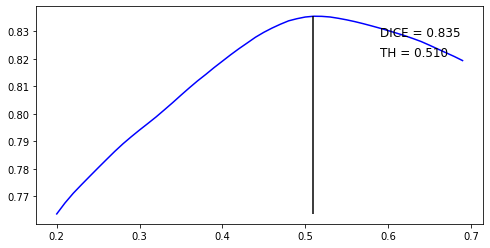

In [13]:
dices = dice.value
noise_ths = dice.ths
best_dice = dices.max()
best_thr = noise_ths[dices.argmax()]
plt.figure(figsize=(8,4))
plt.plot(noise_ths, dices, color='blue')
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max(), colors='black')
d = dices.max() - dices.min()
plt.text(noise_ths[-1]-0.1, best_dice-0.1*d, f'DICE = {best_dice:.3f}', fontsize=12);
plt.text(noise_ths[-1]-0.1, best_dice-0.2*d, f'TH = {best_thr:.3f}', fontsize=12);
plt.show()